## When using a local Jupyter Notebook

In [1]:
%cd C:/Users/nashw/Desktop/ACV/

[Errno 2] No such file or directory: 'C:/Users/nashw/Desktop/ACV/'
/home/d5learner-03/Documents/Advanced_Computer_Vision/ACV-20210922T072422Z-001/ACV


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

### Show an image (in a window)

In [3]:
def show_image(image):
    cv2.imshow('', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
star_mask = cv2.imread('./data/star_mask.jpg')

show_image(star_mask)

### Watch a webcam and apply a filter

In [ ]:
def run_filter_on_camera(image_filter):
    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        # Our operations on the frame come here
        result_image = image_filter(frame)

        # Display the resulting frame
        cv2.imshow('frame', result_image)

        # We break out of the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [3]:
def black_and_white(image):
    return_image = np.zeros((image.shape[0], image.shape[1], 3), np.uint8)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return_image[:, :, 0] = gray
    return_image[:, :, 1] = gray
    return_image[:, :, 2] = gray
    
    return return_image

In [4]:
run_filter_on_camera(black_and_white)

AttributeError: 'NoneType' object has no attribute 'shape'

In [16]:

def left_half(img):
  h, w = img.shape[:2]
  newim = np.zeros((h, w//2, 3), dtype=np.uint8)
  newim[:,:] = img[:,:w//2]
  return newim

def h_flip(img):
  return cv2.flip(img,1)

def sidebyside(imageleft, imageright):
  h1,w1 = imageleft.shape[:2]
  h2,w2 = imageright.shape[:2]
  newimheight = np.max((h1, h2))
  newimwidth = w1 + w2
  newim = np.zeros((newimheight, newimwidth,3), dtype=np.uint8) #on précise le dtype uint8 des images pour eviter une erreur de cast
  newim[:h1, :w1] = imageleft
  newim[:h2,-w2:] = imageright
  return newim


def mirror(img):
  left_half_img = left_half(img)
  left_flip = h_flip(left_half_img)
  mirror = sidebyside(left_half_img, left_flip)
  return mirror

In [17]:
run_filter_on_camera(mirror)

In [ ]:
test = cv2.imread('./data/messi.jpg')

In [ ]:
test_messi = mirror(test)

plt.imshow(test_messi)

## Image Transformations

### Resizing

In [ ]:
scalefactor=2.5

messi = plt.imread('data/messi.jpg')

#the heart of the code:
res = cv2.resize(messi ,None,fx=scalefactor, fy=scalefactor, interpolation = cv2.INTER_CUBIC)

#the remainder of the code is to generate the display image
height, width = messi.shape[:2]

bigwidth = int( np.amax( [scalefactor*height , height]) )
bigheight = int( width*(1+scalefactor))

bigim = np.zeros((bigwidth , bigheight ,3), np.uint8)
bigim[:height,:width] = messi

if scalefactor > 1:
    bigim[:,width:] = res
else:
    bigim[: int(scalefactor*height),width:] = res

plt.figure()
plt.imshow(bigim)

### Translation

In [ ]:
rows,cols,chans = messi.shape

xshift=100
yshift=20

M = np.float32([[1,0,xshift],[0,1,yshift]])
dst = cv2.warpAffine(img,M,(cols,rows))

plt.figure()
plt.imshow(dst)

### Rotation

In [ ]:
rows, cols, chans = messi.shape

#specify our rotation in degrees
theta = 45.0

M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1) 
dst = cv2.warpAffine(messi,M,(cols,rows))
                 
plt.figure()
plt.imshow(dst)

### General affine transform

Map 3 input (x,y) points to 3 output points (ie triangle to triangle)

Will perform translation, scaling, rotation, and skew, but not perspective correction

In [ ]:
rows,cols,ch = messi.shape

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(messi,M,(cols,rows))

plt.figure()
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

### Perspective transform

4 point transform

Nonlinear but more general than affine

Perspective:  further away objects look smaller

In [ ]:
img = plt.imread('day2/right.jpg')
rows,cols,chans = img.shape

startpts =  np.float32([[362, 107], [530,139] , [453,416], [319,337]])
endpts   =  np.float32([[100, 100], [330,100],  [330,400], [100,400]])

M = cv2.getPerspectiveTransform(startpts,endpts)

dst = cv2.warpPerspective(img,M,(rows,cols))

plt.figure()

plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(dst[100:400,100:330])

## Mediapipe presentation

In [ ]:
import mediapipe as mp

drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles

In [3]:
def run_filter_with_mediapipe_model(mediapipe_model, mediapipe_based_filter):
    cap = cv2.VideoCapture(0)
    
    with mediapipe_model as model:
        while cap.isOpened():
            success, image = cap.read()

            if not success:
                print("Ignoring empty camera frame.")
                continue     # If loading a video, use 'break' instead of 'continue'.

            # Flip the image horizontally for a later selfie-view display, and convert
            # the BGR image to RGB.
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            results = model.process(image)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            result_image = mediapipe_based_filter(image, results)

            cv2.imshow('MediaPipe', result_image)

            if cv2.waitKey(5) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

### Holistic (Hands, Face and Pose tracking)

In [5]:
Holistic = mp.solutions.holistic.Holistic

In [6]:
def draw_holistic_results(image, results, show_hands=True, show_face=True, show_pose=False):
    if show_hands:
        drawing_utils.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

        drawing_utils.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

    if show_face:
        drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=drawing_utils.DrawingSpec(thickness=0, circle_radius=0, color=(255, 255, 255)),
            connection_drawing_spec=drawing_styles.get_default_face_mesh_contours_style()
        )

    if show_pose:
        drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_styles.get_default_pose_landmarks_style()
        )
    
    return image

In [11]:
run_filter_with_mediapipe_model(
    mediapipe_model=Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5),
    mediapipe_based_filter=draw_holistic_results
)

### Selfie segmentation model

In [12]:
SelfieSegmentation = mp.solutions.selfie_segmentation.SelfieSegmentation

In [13]:
def draw_selfie_segmentation_mask(image, result):
    return result.segmentation_mask

run_filter_with_mediapipe_model(
    mediapipe_model=SelfieSegmentation(model_selection=0),
    mediapipe_based_filter=draw_selfie_segmentation_mask
)

Nose coordinates: (305.61726093292236, 177.70797729492188


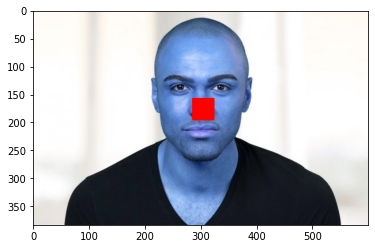

In [14]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

# For static images:
IMAGE_FILES = ['./data/nose.jpg']
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2) as holistic:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.pose_landmarks:
        x_nose = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width
        y_nose = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height
        image[np.int(-20 + y_nose):np.int(y_nose + 20), np.int(-20 + x_nose):np.int(x_nose + 20)] = (255,0,0)
        plt.figure()
        plt.imshow(image)
        print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height}')

In [7]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

def red_nose(image, results):
    height, width, _ = image.shape
    
    if results.pose_landmarks:
        x_nose = results.face_landmarks.landmark[1].x
        y_nose = results.face_landmarks.landmark[1].y
        x_nose2 = results.face_landmarks.landmark[5].x
        y_nose2 = results.face_landmarks.landmark[5].y
        cv2.circle(image,
                  center = (int(x_nose*width), int(y_nose* height)),
                  radius =  int((y_nose - y_nose2)*height), 
                  color = (0,0,255),
                  thickness = -1)
#         print(
#         f'Nose coordinates: ('
#         f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, '
#         f'{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height}')
    return image

run_filter_with_mediapipe_model(
    mediapipe_model=mp_holistic.Holistic(
        static_image_mode=True,
        model_complexity=2
    ),
    mediapipe_based_filter=red_nose,
)

AttributeError: 'NoneType' object has no attribute 'landmark'